## Dyna-Q+: updating action value versus action selection

In this notebook, I conduct some experiments to illustrate the strengths and weaknesses of two different update rules for Dyna-Q+ agents described in Exercise 8.4 of Reinforcement Learning: An Introduction by Richard S. Sutton and Andrew G. Barto. 

In [1]:
import numpy as np
from collections import defaultdict
import sys

if "../" not in sys.path:
      sys.path.append("../") 
        
import matplotlib.pyplot as plt

%matplotlib inline

Time step 15000/15000.

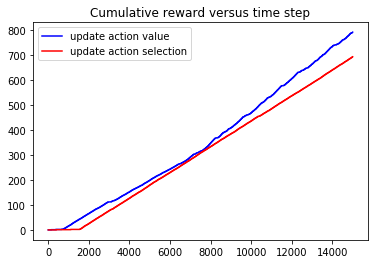

In [2]:
def state_transition(action, state, time_step):
    row_idx, col_idx = state
    done = False
    
    # Environment mechanics
    if action == 0: # Left
        col_idx -= 1
    elif action == 1: # Up
        row_idx += 1
    elif action == 2: # Right
        col_idx += 1
    elif action == 3: # Down
        row_idx -= 1
    
    new_state = (row_idx, col_idx)
    
    # Changes to the environment
    if time_step > 3000:
        time_step_condition = col_idx == 9
    else:
        time_step_condition = False
        
    # Transition
    if new_state == (6, 9):
        reward = 1
        done = True
    else:
        reward = 0
    
    if 0 < col_idx < 10 and 0 < row_idx < 7 and (row_idx != 3 or col_idx == 1 or time_step_condition):
        return reward, new_state, done 
    else:
        return reward, state, done
    
    
def make_epsilon_greedy_policy(Q, ϵ, nA, bonus):
    def policy_fn(state, time_step, last_transition, κ):
        Qs = Q[state].copy()
        
        if bonus == 'selection':  # Update on action selection
            for i in range(nA):
                Qs[i] += κ * np.sqrt(time_step - last_transition[state][i])
                
        A_max = np.random.choice(np.argwhere(Qs == np.max(Qs)).flatten())
        policy = ϵ * np.ones(nA) / nA
        policy[A_max] += (1 - ϵ)
        
        return policy
        
    return policy_fn

    
def dyna_q_plus(time_steps=3000, n=0, α=0.1, γ=0.95, ϵ=0.1, κ=0, bonus_type='value'):
    np.random.seed(0)
    
    nA = 4  # Number of actions
    
    # Action value function
    Q = defaultdict(lambda: np.zeros(nA))
    
    # Model of the environment
    model = defaultdict(lambda: [[]]*4)
    
    # Keeps track of which actions were taken in a given state
    actions_taken = defaultdict(lambda: np.zeros(nA))
    
    # Keeps track of time since last state/action pair
    last_transition = defaultdict(lambda: np.zeros(nA))
    
    # Keeps track of rewards at each time step
    total_rewards = np.zeros(time_steps)
    
    policy = make_epsilon_greedy_policy(Q, ϵ, nA, bonus_type)
    state = (1, 4)
    visited_states = []

    for time_step in range(1, time_steps + 1):
        # Print out which episode we're on, useful for debugging.
        if time_step % 1 == 0:
            print("\rTime step {}/{}.".format(time_step, time_steps), end="")
            sys.stdout.flush()

        # Take action
        action = np.random.choice(nA, p=policy(state, time_step, last_transition, κ))
        reward, next_state, done = state_transition(action, state, time_step)
        
        # Direct RL update
        Q[state][action] += α * (reward + γ * Q[next_state].max() - Q[state][action])

        # Track historical information
        model[state][action] = [reward, next_state]
        last_transition[state][action] = time_step
        visited_states.append(state)
        actions_taken[state][action] = 1

        # Track rewards
        total_rewards[time_step-1] += reward

        # Model update
        for i in range(n):
            # Select random state/action to be updated using model
            random_state = visited_states[np.random.randint(low=0, high=len(visited_states))]
            p = actions_taken[random_state] / actions_taken[random_state].sum()
            random_action = np.random.choice(range(nA), p=p)
            reward_plan, next_state_plan = model[random_state][random_action]
            
            if bonus_type == 'value':  # Update action value
                reward_plan += κ * np.sqrt(time_step - last_transition[random_state][random_action])

            # Update action value
            Q[random_state][random_action] += α * (reward_plan + γ * Q[next_state_plan].max()
                                                   - Q[random_state][random_action])

        state = next_state
        policy = make_epsilon_greedy_policy(Q, ϵ, nA, bonus_type)
            
        if done:
            state = (1, 4)
            visited_states = []

    return Q, model, total_rewards
    
    
Q, model, total_rewards_value = dyna_q_plus(time_steps=15000, α=0.7, n=50, κ=2e-3, bonus_type='value');
Q, model, total_rewards_selection = dyna_q_plus(time_steps=15000, α=0.7, n=50, κ=2e-3, bonus_type='selection');

plt.plot(np.cumsum(total_rewards_value), color='b', label='update action value')
plt.plot(np.cumsum(total_rewards_selection), color='r', label='update action selection')
plt.title('Cumulative reward versus time step')
plt.legend();

Time step 15000/15000.

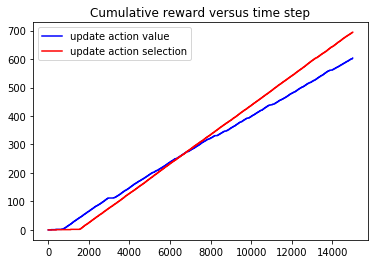

In [3]:
def state_transition(action, state, time_step):
    row_idx, col_idx = state
    done = False
    
    # Environment mechanics
    if action == 0: # Left
        col_idx -= 1
    elif action == 1: # Up
        row_idx += 1
    elif action == 2: # Right
        col_idx += 1
    elif action == 3: # Down
        row_idx -= 1
    
    new_state = (row_idx, col_idx)
    
    # Transition
    if new_state == (6, 9):
        reward = 1
        done = True
    else:
        reward = 0
      
    if 0 < col_idx < 10 and 0 < row_idx < 7 and (row_idx != 3 or col_idx == 1):
        return reward, new_state, done 
    else:
        return reward, state, done
    
Q, model, total_rewards_value = dyna_q_plus(time_steps=15000, α=0.7, n=50, κ=2e-3, bonus_type='value');
Q, model, total_rewards_selection = dyna_q_plus(time_steps=15000, α=0.7, n=50, κ=2e-3, bonus_type='selection');

plt.plot(np.cumsum(total_rewards_value), color='b', label='update action value')
plt.plot(np.cumsum(total_rewards_selection), color='r', label='update action selection')
plt.title('Cumulative reward versus time step')
plt.legend();

Time step 15000/15000.

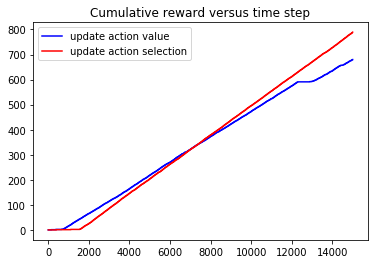

In [4]:
def state_transition(action, state, time_step):
    row_idx, col_idx = state
    done = False
    
    # Environment mechanics
    if action == 0: # Left
        col_idx -= 1
    elif action == 1: # Up
        row_idx += 1
    elif action == 2: # Right
        col_idx += 1
    elif action == 3: # Down
        row_idx -= 1
    
    new_state = (row_idx, col_idx)
    
    # Changes to the environment
    if time_step > 2000:
        time_step_condition = col_idx == 2
    elif time_step > 4000:
        time_step_condition = col_idx == 3
    elif time_step > 6000:
        time_step_condition = col_idx == 4
    elif time_step > 8000:
        time_step_condition = col_idx == 5
    elif time_step > 10000:
        time_step_condition = col_idx == 6
    elif time_step > 12000:
        time_step_condition = col_idx == 7
    else:
        time_step_condition = False
        
    # Transition
    if new_state == (6, 9):
        reward = 1
        done = True
    else:
        reward = 0
    
    if 0 < col_idx < 10 and 0 < row_idx < 7 and (row_idx != 3 or col_idx == 1 or time_step_condition):
        return reward, new_state, done 
    else:
        return reward, state, done
    
Q, model, total_rewards_value = dyna_q_plus(time_steps=15000, α=0.7, n=50, κ=2e-3, bonus_type='value');
Q, model, total_rewards_selection = dyna_q_plus(time_steps=15000, α=0.7, n=50, κ=2e-3, bonus_type='selection');

plt.plot(np.cumsum(total_rewards_value), color='b', label='update action value')
plt.plot(np.cumsum(total_rewards_selection), color='r', label='update action selection')
plt.title('Cumulative reward versus time step')
plt.legend();

## Comments

Note: The algorithms are *very* sensitive to changes in parameter values (random seed, learning rate, $\kappa$, $n$).

With updates on action selection:
- Action values estimates remain unbiased if there are no changes in the environment
- Performance is better if there are no or small changes in the environment
- Performance is worse if there is a big change in the environment